## Experiment 01


### Loading related functions and libraries

In [124]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
random.seed(1337)

def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value

### Loading preprocessed data by Richardson

Creates three dictionaries:
 * `richardson_data`
 
 All choices as vectors, e.g. `{'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2] ...`
 
 * `richardson_categorial`
 
 Maximum choice as binary choice, e.g. `{'fled': [0, 0, 1, 0], 'pointed at': [0, 0, 0, 1] ...`
 
 * `richardson_normed`
 
 Maximum choice divided by all choices, disregarding all other choices, e.g.  `{'fled': [0.0, 0.0, 0.808, 0.0], 'pointed at': [0.0, 0.0, 0.0, 0.892] ...`
 

In [125]:
with open("../../data/richardson_actions.txt", "r") as d_in:
    lines = [line.split() for line in d_in.readlines()]

output = []
for entry in lines:
    new_entry = [convert_to_float(item) for item in entry]
    
    if isinstance(new_entry[1],str):
        new_entry[0] = " ".join(new_entry[:2])
        del new_entry[1]
    output.append(new_entry)

richardson_data = dict()
for elem in output:
    richardson_data[elem[0]] = [i for i in elem[1:]]

# Randomizing Richardson's data
action_words = list(richardson_data.keys())
random.shuffle(action_words)

richardson_categorial = dict()
for k, v in richardson_data.items():
    if k == 0:
        continue
    vals = [0,0,0,0]
    vals[v.index(max(v))] = 1

    richardson_categorial[k] = vals
richardson_normed = dict()

for action, values in richardson_data.items():
    if action == 0:
        continue
    
    richardson_normed[action] = [round(val/sum(values),4) for val in values]

## Choose model type

In [126]:
model_type = "meta-llama"
model_name = "Llama-2-70b-hf"

## Load model results

In [127]:
model_choices = dict()
with open("results/exp01a_"+model_name+".txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

In [128]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5):
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9901663377226431, 'pointed at': 0.0, 'pulled': 0.9795876356616771, 'pushed': 0.01357841432268506, 'walked': 0.924763039831037, 'hunted': 0.9493026472305787, 'impacted': 0.046211084910339865, 'perched': 0.9817515577580416, 'showed': 0.14795277584556701, 'smashed': 0.3957081444379261, 'bombed': 0.07568687895144977, 'flew': 0.04987698326518423, 'floated': 0.04563330124259875, 'lifted': 0.027284991362894712, 'sank': 0.953734413319121, 'argued with': 0.1908116511593712, 'gave to': 0.014668216871254868, 'offended': 0.45719378941948374, 'rushed': 0.8933406045639222, 'warned': 0.09067324337954895, 'owned': 0.29807654031533926, 'regretted': 0.7670897312644317, 'rested': 0.7057256562731608, 'tempted': 0.4668127501188908, 'wanted': 0.9338567516961644, 'hoped': 0.26871242051024596, 'increased': 0.12764095459848068, 'obeyed': 0.9344356036419196, 'respected': 0.047762102914633286, 'succeeded': 0.2337949951526904}
{'Horizontal': 0.3967, 'Neutral': 0.425, 'Vertical': 0.0397, 'Horizon.': 0.3

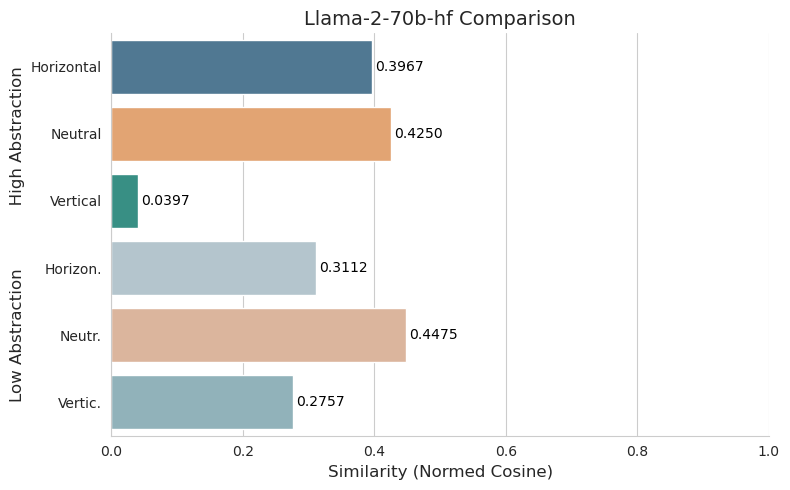

In [129]:
data = similarity_scores_constructs

# Set a custom color palette
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

# Create a horizontal bar plot using Seaborn
plt.figure(figsize=(8, 5))

sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=12)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=12)
plt.title(model_name+' Comparison', fontsize=14)

# Adding data values next to the bars
for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=10, color='black')

# Set x-axis limits
plt.xlim(0, 1)

# Remove spines (borders) from the plot
sns.despine()

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig("results/exp01a_"+model_name+"_CosSim.png")
plt.show()


In [130]:
from IPython.display import Markdown as md
average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
md("## The average similarity is: **{}** ".format(average_sim))

# random: 
# llama2-7b: 0.374
# llama2-13b: 0.347
# llama2-70b: 0.316


## The average similarity is: **0.3159666666666667** 

## Cohen's Kappa

In [131]:
from sklearn.metrics import cohen_kappa_score

existing_percentages = richardson_data
existing_responses = []
model_responses = []

for action in existing_percentages:
    existing_responses.append(existing_percentages[action].index(max(existing_percentages[action])))
    model_responses.append(model_choices[action].index(1))  # Assuming 1 indicates model's choice

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(existing_responses, model_responses)
print("Cohen's Kappa:", kappa)


Cohen's Kappa: 0.13109756097560976


* **Less than 0**: Indicates no agreement or even less agreement than would be expected by chance.
* **0**: Represents the level of agreement that would be expected by chance alone.
* **Greater than 0**: Indicates agreement beyond chance.

llama-2 7b: -0.0345

llama-2 13b: 0.0948

llama-2 70b: 0.1311


In [132]:
print(richardson_normed)
print(model_choices)

{'fled': [0.072, 0.042, 0.808, 0.078], 'pointed at': [0.072, 0.036, 0.0, 0.892], 'pulled': [0.06, 0.054, 0.754, 0.132], 'pushed': [0.072, 0.036, 0.012, 0.88], 'walked': [0.0905, 0.0362, 0.2412, 0.6322], 'hunted': [0.0959, 0.2038, 0.018, 0.6823], 'impacted': [0.072, 0.371, 0.03, 0.527], 'perched': [0.12, 0.76, 0.066, 0.054], 'showed': [0.1499, 0.0899, 0.1019, 0.6583], 'smashed': [0.036, 0.665, 0.012, 0.287], 'bombed': [0.048, 0.868, 0.018, 0.066], 'flew': [0.377, 0.443, 0.15, 0.03], 'floated': [0.329, 0.563, 0.078, 0.03], 'lifted': [0.874, 0.096, 0.024, 0.006], 'sank': [0.2218, 0.7183, 0.042, 0.018], 'argued with': [0.1139, 0.1379, 0.1259, 0.6224], 'gave to': [0.084, 0.096, 0.012, 0.808], 'offended': [0.09, 0.317, 0.246, 0.347], 'rushed': [0.1025, 0.1085, 0.2352, 0.5538], 'warned': [0.1079, 0.2218, 0.0599, 0.6104], 'owned': [0.0539, 0.5564, 0.1858, 0.2038], 'regretted': [0.1978, 0.2398, 0.4126, 0.1499], 'rested': [0.144, 0.365, 0.401, 0.09], 'tempted': [0.168, 0.114, 0.455, 0.263], 'wan

/tmp/ipykernel_1311658/3586475748.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


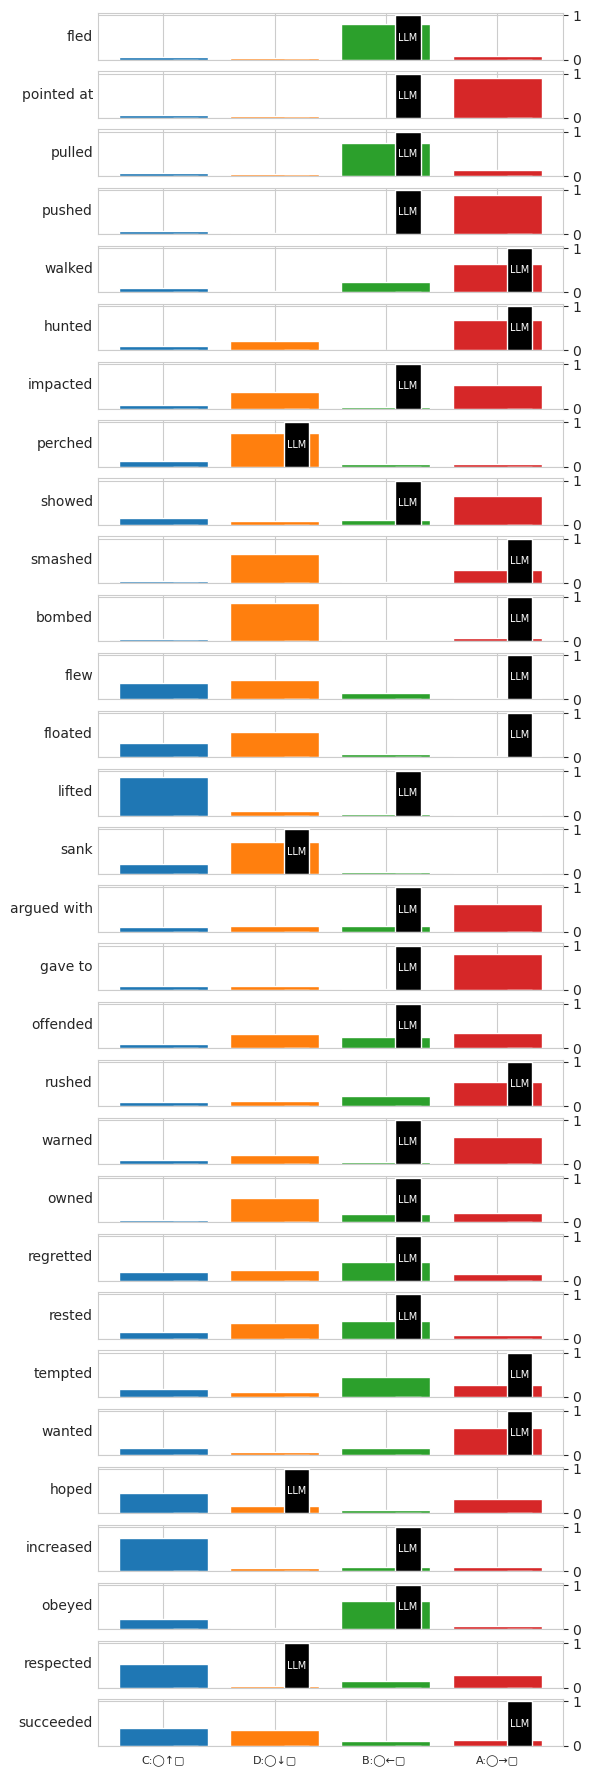

In [133]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_normed
data_new = model_choices

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.8  # Width of the old bars
bar_width_new = bar_width_old / 3.5  # Width of the new bars

for i, action in enumerate(action_names):
    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots)
    positions_new = positions_old + bar_width_old / 4  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        ax.bar(positions_old[j], value_old, bottom=bottom_old[j], width=bar_width_old)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j], value_new, bottom=bottom_new[j], width=bar_width_new, color="black")
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        
        if value_new == 1:
            ax.text(new_bar_x, value_new / 2, "LLM", ha='center', va='center', color='white', fontsize=fig_width+1) # Adjust fontsize as needed
                

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢'], fontsize=8)  # Adjust fontsize as needed
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right')

plt.tight_layout()
plt.savefig("results/exp01a_"+model_name+"_Choices.png")
plt.show()
